In [64]:
import requests
import json
from pathlib import Path
import glob
import time
from pprint import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

In [3]:
def num_files(tier_code):
    files = glob.glob('./data/match_info/%d*.json'%tier_code)
    print(f"There exist {len(files):>5} files for tier_code {tier_code}")

In [4]:
def summoner_in_match(path):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    return summoner_list

In [5]:
def is_summoner(path, summoner_name):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    if summoner_name in summoner_list:
        return True
    else:
        return False

In [6]:
def match_by_summoner(summoner_name):
    matches = []
    for tier in range(1,6):
        print(f"Searching Tier Code {tier}")
        num_matches = len(matches)
        files = glob.glob(f'./data/match_info/{tier}*.json')
        for file in files:
            if is_summoner(file, summoner_name):
                matches.append(file)
        if(num_matches != len(matches)):
            break
    return matches

In [7]:
def generate_sumlist():
    summoners = {}
    files = glob.glob('./data/match_info/*')
    files_num = len(files)
    count = 0
    start_time = time.time()
    for file in files:
        count = count + 1
        sum_list = summoner_in_match(file)
        for summonor in sum_list:
            if(summonor not in summoners):
                summoners[summonor] = 1
            else:
                summoners[summonor] = summoners[summonor] + 1
        print(f'{count}/{files_num}', end = '\r')
    print(time.time()-start_time)
    return summoners

In [53]:
def pts_extracter(match_id, summoner_name):
    timeline_path = f'./data/match_timeline\\{match_id}.json'
    info_path = f'./data/match_info\\{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    for parts in info_dic['participantIdentities']:
        if(parts['player']['summonerName'] == summoner_name):
            ingameId = parts['participantId']
            break
    x = []
    y = []
    for frame in tl_dic['frames']:
        try:
            x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
            y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
            for event in frame['events']:
                if (event['type'] == 'CHAMPION_KILL'):
                    if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                        x.append(event['position']['x'])
                        y.append(event['position']['y'])
        except:
            pass
    return x,y

In [9]:
def heatmap(x, y, s, bins):
    heatmap, xedge, yedge = np.histogram2d(x, y, range = [[0, 15000], [0, 15000]], bins=bins)    
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T

def show_heat_scatter(x,y,s, bins = 500):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig = plt.figure(figsize=(5,10))
    extent = [0,15000,0,15000]
    
    axs[0].plot(x, y, 'b.', markersize=10)
    axs[0].set_xlim([0, 15000])
    axs[0].set_ylim([0, 15000])
    axs[0].set_title("Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[0].imshow(img, zorder=0, extent=extent)

    heat = heatmap(x, y, s, bins)
    axs[1].imshow(heat, extent = extent, origin='lower', cmap=cm.jet)
    
    axs[1].set_title("Smoothing with  $\sigma$ = %d" % s)
    plt.show()

In [83]:
def get_itemname(items_dic, item_id):
    try:
        return items_dic['data'][f'{item_id}']['name']
    except:
        return (f"INVALID_ITEM(id : {item_id})")

In [185]:
#destroy, undo, purchsed, sold
def item_tech(match_id, part_id):
    tl = Path(f"./data/match_timeline/{match_id}.json").read_bytes()
    tl_dic = json.loads(tl.decode())
    
    #local
    #items = Path("./data/item_cdn.json").read_bytes()
    #items_dic = json.loads(items.decode())
    
    #online
    version = "10.16.1"
    items_dic = (requests.get(f"http://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/item.json")).json()
    
    inventory = []
    minutes = 0
    for frame in tl_dic['frames']:
        past_inv = inventory.copy()
        if len(frame['events']) == 0:
            continue
        else:
            for event in frame['events']:
                try: 
                    if event['participantId'] == part_id:
                        event_time = time.strftime("%M:%S", time.gmtime(event['timestamp']/1000))
                        if event['type'] == "ITEM_PURCHASED":
                            inventory.append(event["itemId"])
                            #print(f'\t{event_time}  Purchased {get_itemname(items_dic, event["itemId"])}')
                        elif event['type'] == "ITEM_SOLD":
                            del inventory[inventory.index(event["itemId"])]
                            print(f'\t- {event_time}  Sold {get_itemname(items_dic, event["itemId"])} ', end ='')
                            print(list(map(lambda x : get_itemname(items_dic, x), inventory)))
                        elif event['type'] == "ITEM_DESTROYED":
                            del inventory[inventory.index(event["itemId"])]
                            #print(f'\t{event_time}  Destroyed {get_itemname(items_dic, event["itemId"])}')
                        elif event['type'] == "ITEM_UNDO":
                            inventory.append(event["afterId"])
                            del inventory[inventory.index(event["beforeId"])]
                            #print(f'\t{event_time}  Undo {get_itemname(items_dic, event["beforeId"])} to {get_itemname(items_dic, event["afterId"])}')
                        else:
                            continue
                    else:
                        continue
                except:
                    pass
        minutes = minutes + 1
        while(0 in inventory):
            del inventory[inventory.index(0)]
        if (past_inv != inventory):
            print(f"- {minutes} min : ", end ='')
            print(list(map(lambda x : get_itemname(items_dic, x), inventory)))

In [186]:
item_tech(mts[1][18:30],1)

- 1 min : ["Doran's Ring", 'Health Potion', 'Health Potion', 'Warding Totem (Trinket)']
- 4 min : ["Doran's Ring", 'Warding Totem (Trinket)']
- 6 min : ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Boots of Speed', 'Dark Seal', 'Control Ward', 'Faerie Charm']
	- 06:51  Sold Faerie Charm ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Boots of Speed', 'Dark Seal']
- 7 min : ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Dark Seal', "Sorcerer's Shoes"]
- 9 min : ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Dark Seal', "Sorcerer's Shoes", 'Amplifying Tome', 'Control Ward']
- 10 min : ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Dark Seal', "Sorcerer's Shoes", 'Amplifying Tome']
- 11 min : ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Dark Seal', "Sorcerer's Shoes", 'Lost Chapter']
- 14 min : ["Doran's Ring", 'Warding Totem (Trinket)', 'Refillable Potion', 'Dark Seal', "So

In [136]:
for i in range(1,6):
    num_files(i)

There exist  5304 files for tier_code 1
There exist  5322 files for tier_code 2
There exist  5139 files for tier_code 3
There exist  4924 files for tier_code 4
There exist  4796 files for tier_code 5


In [11]:
files = glob.glob('./data/match_info/5*.json')
print(summoner_in_match(files[1000]))
print(is_summoner(files[1000],"콘지돔"))

['소주먹은꽐라', 'PERIO2', '오랜지쥬시쿨', '논현동귀염둥이', '콘지돔', '착한일하는사람', 'LOLPRATICE', '냥뉴뉴', '배달장인고춘이', '남탓하면고소미']
True


In [12]:
mts = match_by_summoner('이호나')

Searching Tier Code 1


In [15]:
print(f'There exist {len(mts)} matches')

There exist 98 matches


8


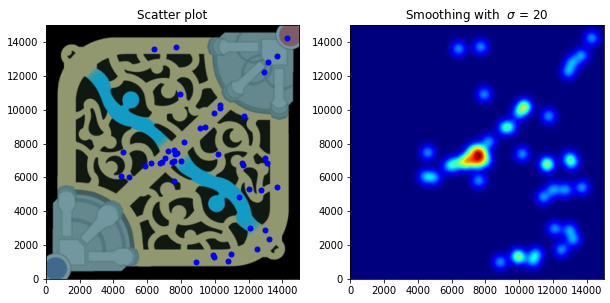

<Figure size 360x720 with 0 Axes>

In [52]:
index = 4
x,y = pts_extracter(mts[index][18:30], '이호나')
show_heat_scatter(x,y,20,1000)

In [139]:
test = Path(f"./data/match_info/{mts[1][18:30]}.json").read_bytes()
test = json.loads(test.decode())
test

{'gameId': 4440027341,
 'platformId': 'KR',
 'gameCreation': 1591807199614,
 'gameDuration': 1801,
 'queueId': 420,
 'mapId': 11,
 'seasonId': 13,
 'gameVersion': '10.12.323.8771',
 'gameMode': 'CLASSIC',
 'gameType': 'MATCHED_GAME',
 'teams': [{'teamId': 100,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': True,
   'firstDragon': False,
   'firstRiftHerald': True,
   'towerKills': 7,
   'inhibitorKills': 2,
   'baronKills': 1,
   'dragonKills': 3,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 60, 'pickTurn': 1},
    {'championId': 81, 'pickTurn': 2},
    {'championId': 58, 'pickTurn': 3},
    {'championId': 134, 'pickTurn': 4},
    {'championId': 89, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': False,
   'firstDragon': True,
   'firstRiftHerald': False,
   'towerKills':

In [164]:
items = (requests.get(f"http://ddragon.leagueoflegends.com/cdn/11.1.1/data/en_US/item.json")).json()
items

{'type': 'item',
 'version': '11.1.1',
 'basic': {'name': '',
  'rune': {'isrune': False, 'tier': 1, 'type': 'red'},
  'gold': {'base': 0, 'total': 0, 'sell': 0, 'purchasable': False},
  'group': '',
  'description': '',
  'colloq': ';',
  'plaintext': '',
  'consumed': False,
  'stacks': 1,
  'depth': 1,
  'consumeOnFull': False,
  'from': [],
  'into': [],
  'specialRecipe': 0,
  'inStore': True,
  'hideFromAll': False,
  'requiredChampion': '',
  'requiredAlly': '',
  'stats': {'FlatHPPoolMod': 0,
   'rFlatHPModPerLevel': 0,
   'FlatMPPoolMod': 0,
   'rFlatMPModPerLevel': 0,
   'PercentHPPoolMod': 0,
   'PercentMPPoolMod': 0,
   'FlatHPRegenMod': 0,
   'rFlatHPRegenModPerLevel': 0,
   'PercentHPRegenMod': 0,
   'FlatMPRegenMod': 0,
   'rFlatMPRegenModPerLevel': 0,
   'PercentMPRegenMod': 0,
   'FlatArmorMod': 0,
   'rFlatArmorModPerLevel': 0,
   'PercentArmorMod': 0,
   'rFlatArmorPenetrationMod': 0,
   'rFlatArmorPenetrationModPerLevel': 0,
   'rPercentArmorPenetrationMod': 0,
   '